## Note: this notebook is trained on STATS department server alan since the dataset is very large.  

In [18]:
# import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random
import nltk
from nltk.corpus import stopwords 
import string
from gensim.models import KeyedVectors
from wordcloud import WordCloud, STOPWORDS
import time

from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Sequential, Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [19]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train shape:", train.shape)
print("Test shape:", test.shape)
target = train['target'].values
## split to train and val
train_df, val_df = train_test_split(train, test_size=0.1, random_state=1024)
test_df = test

## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

Train shape: (1306122, 3)
Test shape: (375806, 2)


In [20]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values

## Unpretrained BiLSTM

In [22]:
# Jue's newly constructed NN model
model = Sequential()
model.add(Embedding(max_features, embed_size, input_length=maxlen))
model.add(Bidirectional(LSTM(40, dropout=0.2, recurrent_dropout=0.3,return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.3))
model.add(Dense(20,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(train_X, train_y, batch_size=256, epochs=4, validation_data=(val_X, val_y))

pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.601, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 80)           109120    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 80)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1620      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

/Users/jp/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1175509 samples, validate on 130613 samples
Epoch 1/4
  74240/1175509 [>.............................] - ETA: 44:10 - loss: 0.2040 - accuracy: 0.9380

KeyboardInterrupt: 

## Pretrained BiLSTM

We have four different types of embeddings:
1. GoogleNews-vectors-negative300 (Word2Vec)
2. glove.840B.300d (GloVe)
3. paragram_300_sl999
4. wiki_news_300d-1M

## 1. Word2Vec using Gensim

In [15]:
EMBEDDING_FILE = './embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
embeddings_index = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary= True)

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = (np.random.rand(nb_words, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= max_features: continue
    if word in embeddings_index:
        embedding_vector = embeddings_index.get_vector(word)
        embedding_matrix[i] = embedding_vector
        

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(40,dropout=0.2, recurrent_dropout=0.3, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.3)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(train_X, train_y, batch_size=256, epochs=4, validation_data=(val_X, val_y))
pred_word2vec_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("For Word2Vec, F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_word2vec_val_y>thresh).astype(int))))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          186880    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17  

## Glove Embeddings

In [ ]:
EMBEDDING_FILE = './embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(40, dropout=0.2, recurrent_dropout=0.3,return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.3)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(train_X, train_y, batch_size=256, epochs=4, validation_data=(val_X, val_y))

pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("For Glove, F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))

## Wiki News FastText Embedding

In [ ]:
EMBEDDING_FILE = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(40,dropout=0.2, recurrent_dropout=0.3, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.3)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(train_X, train_y, batch_size=256, epochs=4, validation_data=(val_X, val_y))
pred_fasttext_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("For fasttext, F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_fasttext_val_y>thresh).astype(int))))

## Paragram Embedding

In [ ]:
EMBEDDING_FILE = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continIue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(40,dropout=0.2, recurrent_dropout=0.3, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.3)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(train_X, train_y, batch_size=256, epochs=4, validation_data=(val_X, val_y))
pred_paragram_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("For paragram, F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_paragram_val_y>thresh).astype(int))))

The results below are obtained from STATS alan server by running our models on that.

## Results comparison

In [90]:
all_losses = {
    'baseline_loss': [0.1249, 0.1031, 0.0928, 0.0839],
    'baseline_val_loss': [0.1119, 0.1101, 0.1139, 0.1211],
    'word2vec_loss': [0.1198,0.1005, 0.091, 0.0829],
    'word2vec_val_loss': [0.1084,0.1092, 0.1092, 0.1131],
    'glove_loss': [0.1173, 0.1003, 0.0924, 0.0861],
    'glove_val_loss': [0.107, 0.1047, 0.1081, 0.1082],
    'fasttext_loss': [0.1199, 0.1001, 0.0901, 0.0817],
    'fasttext_val_loss': [0.1098, 0.1086, 0.1122, 0.1169],
    'paragram_loss': [0.1207, 0.1025, 0.0957, 0.0901],
    'paragram_val_loss': [0.1086, 0.1071, 0.108, 0.11]
}

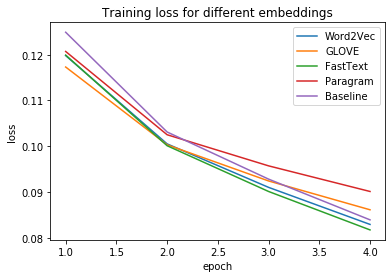

In [91]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['word2vec_loss'])
plt.plot(epochRange,all_losses['glove_loss'])
plt.plot(epochRange,all_losses['fasttext_loss'])
plt.plot(epochRange,all_losses['paragram_loss'])
plt.plot(epochRange,all_losses['baseline_loss'])
plt.title('Training loss for different embeddings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Word2Vec', 'GLOVE','FastText','Paragram', 'Baseline'], loc='upper right')
plt.show()

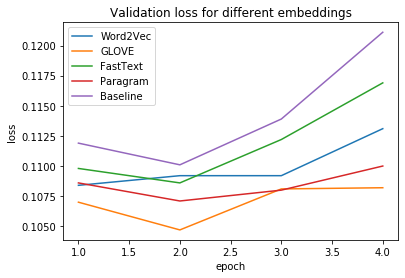

In [92]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['word2vec_val_loss'])
plt.plot(epochRange,all_losses['glove_val_loss'])
plt.plot(epochRange,all_losses['fasttext_val_loss'])
plt.plot(epochRange,all_losses['paragram_val_loss'])
plt.plot(epochRange,all_losses['baseline_val_loss'])
plt.title('Validation loss for different embeddings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Word2Vec', 'GLOVE','FastText','Paragram', 'Baseline'], loc='upper left')
plt.show()

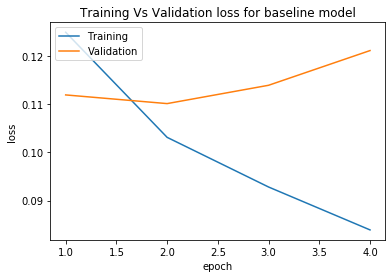

In [93]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['baseline_loss'])
plt.plot(epochRange,all_losses['baseline_val_loss'])
plt.title('Training Vs Validation loss for baseline model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

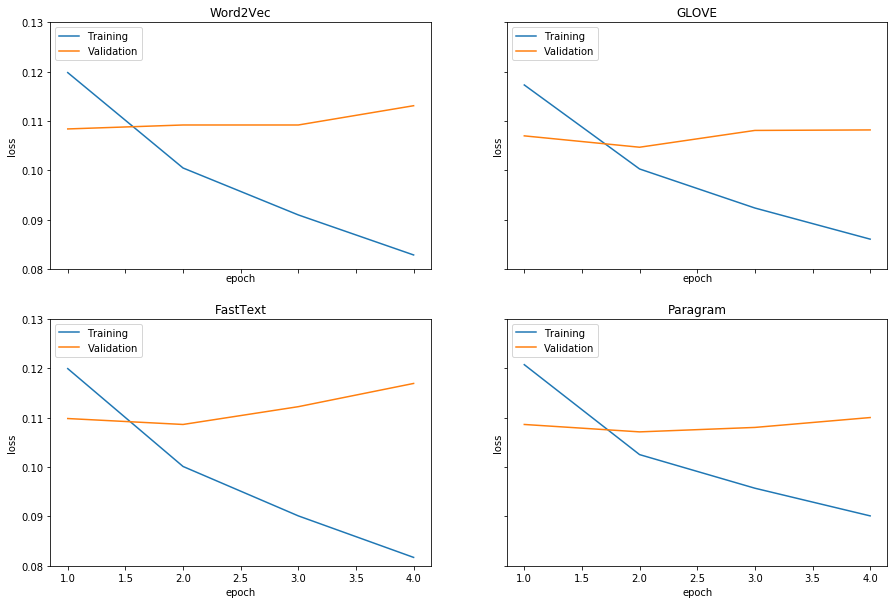

In [106]:
f, ((ax2, ax3), (ax4, ax5)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(15, 10))

plt.title('Training Vs Validation loss for all embeddings')



ax2.plot(epochRange,all_losses['word2vec_loss'])
ax2.plot(epochRange,all_losses['word2vec_val_loss'])
ax2.set_title('Word2Vec')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['Training', 'Validation'], loc='upper left')

ax2.set_ylim(0.08, 0.13)

ax3.plot(epochRange,all_losses['glove_loss'])
ax3.plot(epochRange,all_losses['glove_val_loss'])
ax3.set_title('GLOVE')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.legend(['Training', 'Validation'], loc='upper left')

ax3.set_ylim(0.08, 0.13)


ax4.plot(epochRange,all_losses['fasttext_loss'])
ax4.plot(epochRange,all_losses['fasttext_val_loss'])
ax4.set_title('FastText')
ax4.set_ylabel('loss')
ax4.set_xlabel('epoch')
ax4.legend(['Training', 'Validation'], loc='upper left')

ax4.set_ylim(0.08, 0.13)

ax5.plot(epochRange,all_losses['paragram_loss'])
ax5.plot(epochRange,all_losses['paragram_val_loss'])
ax5.set_title('Paragram')
ax5.set_ylabel('loss')
ax5.set_xlabel('epoch')
ax5.legend(['Training', 'Validation'], loc='upper left')

ax5.set_ylim(0.08, 0.13)



plt.show()

In [95]:
# best F1 score achievced for each algorithm for all data

In [85]:
F_score = {'baseline': 0.64504,
          'Word2Vec': 0.6595,
          'Glove': 0.6715,
          "FastText": 0.6514,
          "Paragram": 0.6692}
keys = F_score.keys()
values = F_score.values()

Text(0, 0.5, 'F1 score')

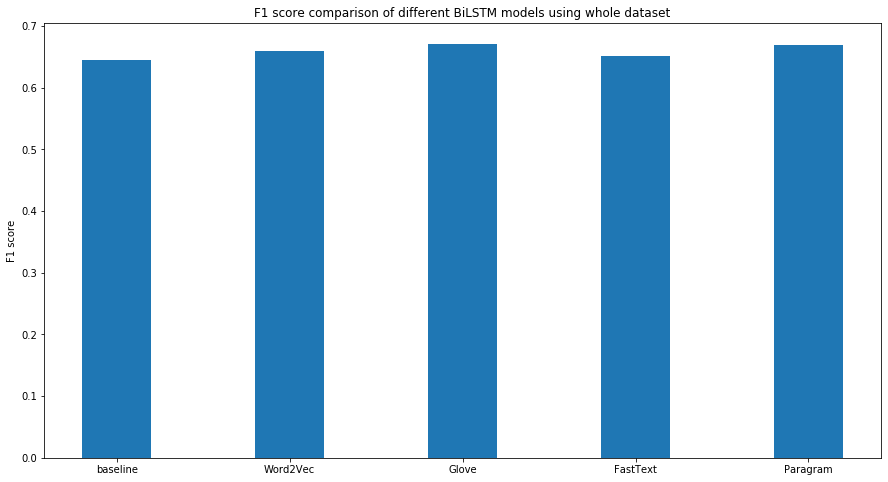

In [86]:
plt.figure(figsize=(15, 8))
plt.bar(keys, values, width = 0.4)
plt.title('F1 score comparison of different BiLSTM models using whole dataset')
plt.ylabel('F1 score')

In [87]:
# Best F1 score achieved for each algorithm for 100k data

In [88]:
F_score_sub = {'LogisticRegression': 0.498353,
              'GaussianNB': 0.166821,
              'baselineNN': 0.559462,
              'Word2Vec': 0.58,
              'Glove': 0.5891,
              'FastText': 0.5818,
              'Paragram': 0.5849}
keys = F_score_sub.keys()
values = F_score_sub.values()

Text(0, 0.5, 'F1 score')

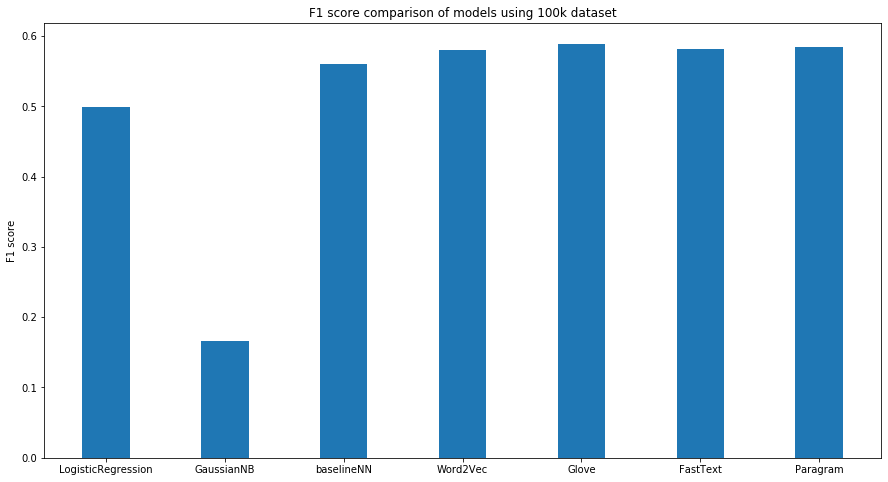

In [89]:
plt.figure(figsize=(15, 8))
plt.bar(keys, values, width = 0.4)
plt.title('My title')
plt.title('F1 score comparison of models using 100k dataset')
plt.ylabel('F1 score')